In [39]:
import numpy as np
import pandas as pd
from utils import DataManipulation, Measures

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.pipeline import Pipeline

plt.style.use("ggplot")
pd.set_option('display.max_columns', 200)

In [2]:
data = pd.read_csv('./data/advertising.csv')

In [3]:
n, m = data.shape
print(f'Rows: {n} \nFeatures: {m}')

Rows: 200 
Features: 5


In [4]:
data.drop("Idx", axis=1, inplace=True)

In [5]:
data.head(10)

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
5,8.7,48.9,75.0,7.2
6,57.5,32.8,23.5,11.8
7,120.2,19.6,11.6,13.2
8,8.6,2.1,1.0,4.8
9,199.8,2.6,21.2,10.6


In [6]:
data.columns

Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')

In [7]:
data.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [8]:
data.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


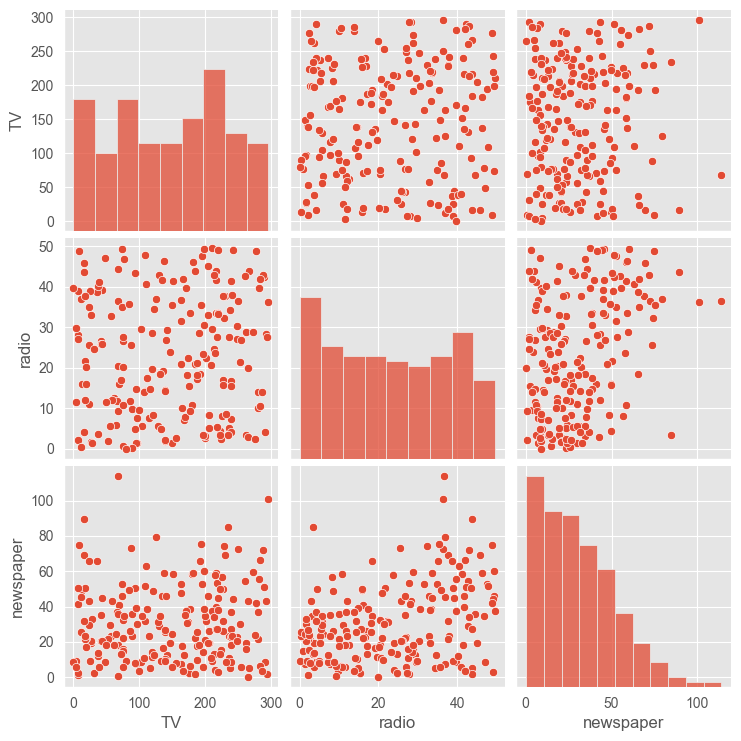

In [10]:
indp_vars = ["TV", "radio", "newspaper"]
ax = sns.pairplot(data=data, vars=indp_vars)
plt.rcParams["figure.figsize"] = (5,4)
plt.show()

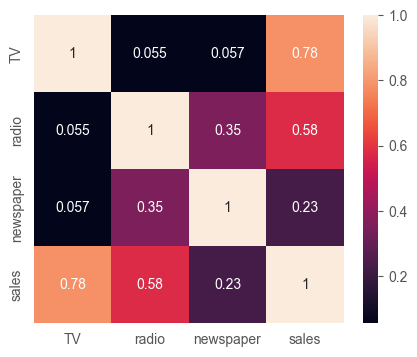

In [11]:
sns.heatmap(data.corr(), annot=True)
plt.rcParams["figure.figsize"] = (9,6)
plt.show()

In [12]:
target = 'sales'

data_norm = DataManipulation.z_score_normalization(data)

X = data_norm.drop([target], axis=1)
y = data_norm[target]

In [13]:
k, TEST_SIZE, SEED = 5, 0.3, 42

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

folds = DataManipulation.kfold(X_train, y_train, k)

In [14]:
def predict(W, X, b) -> pd.Series:
    return np.dot(X, W.T) + b if not np.any(np.isnan(W)) else np.full((X.shape[0], 1), float('inf'))

In [15]:
def calc_mse(y_actual, y_hat, n):
    return (1 / 2*n) * np.sum(((y_actual - y_hat)**2))

In [16]:
def calc_gradient(W, X, b, y, n):
    y_hat = predict(W, X, b)
    error = y_hat.flatten() - y
    
    dy_dW = (1 / n) * np.dot(X.T, error)
    dy_db = (1 / n) * np.sum(error)
    
    return dy_db, dy_dW

In [17]:
def gd(W, X, b, y, n, iterations, alpha):
    
    error_hist = []
    
    for i in range(iterations):
        dy_db, dy_dW = calc_gradient(W, X, b, y, n)
        
        b -= alpha * dy_db
        W -= alpha * dy_dW
        
        error_hist.append(calc_mse(y, predict(W, X, b).flatten(), X.shape[0]))
    
    return W, b, error_hist

In [18]:
initial_W, initial_b, iterations = np.zeros((1,X_train.shape[1])), 0, 1000
alphas = [0.1, 0.3, 0.01, 0.03, 0.001, 0.003, 0.0001, 0.0003, 0.00001, 0.00003]

min_val_error, best_alpha, best_W, best_b, best_err_hist = float('inf'), None, None, None, None

for alpha in alphas:
    for train_data, val_data in folds:
        X_train_curr = np.delete(train_data, -1, axis=1)
        y_train_curr = train_data[:, -1]
    
        X_val_curr = val_data.drop([target], axis=1)
        y_val_curr = val_data[target]    
        
        
        n, m = X_train_curr.shape
        
        curr_W, curr_b, curr_error_hist = gd(initial_W, X_train_curr, initial_b, y_train_curr, n, iterations, alpha)
        
        val_error = calc_mse(y_val_curr, predict(curr_W, X_val_curr, curr_b).flatten(), X_val_curr.shape[0])
        # plt.plot([x for x in range(iterations)], curr_error_hist)
        # plt.show()
        if val_error < min_val_error and not np.any(np.isnan(curr_W)):
            min_val_error = val_error 
            best_alpha = alpha
            best_W = curr_W
            best_b = curr_b
            best_err_hist = curr_error_hist
            
print(best_alpha, min_val_error)
print(best_W)
print(best_b)
    

3e-05 26.766671352061273
[[0.72017382 0.57031083 0.029108  ]]
0.00012115690931734774


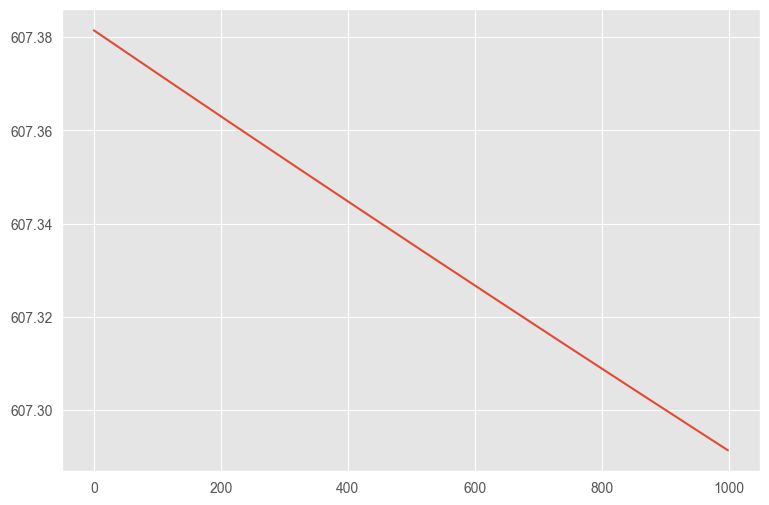

In [19]:
plt.plot([x for x in range(iterations)], best_err_hist)
plt.show()

In [20]:
sgdr = linear_model.SGDRegressor(max_iter=100000)
sgdr.fit(X_train, y_train)

SGDRegressor(max_iter=100000)

In [21]:
mse_sgdr = metrics.mean_squared_error(y_test, sgdr.predict(X_test))
r_2_sgdr = metrics.r2_score(y_test, sgdr.predict(X_test))

mse_custom = metrics.mean_squared_error(y_test, predict(best_W, X_test, best_b))
r_2_custom = metrics.r2_score(y_test, predict(best_W, X_test, best_b))

print("<----- Sklearn SDG regression Benchmark ----->")
print(f"MSE: {mse_sgdr*100:.2f}%")
print(f"R_2: {r_2_sgdr*100:.2f}%")
print("<----- Custom SDG regression Benchmark ----->")
print(f"MSE: {mse_custom*100:.2f}%")
print(f"R_2: {r_2_custom*100:.2f}%")

<----- Sklearn SDG regression Benchmark ----->
MSE: 14.41%
R_2: 85.63%
<----- Custom SDG regression Benchmark ----->
MSE: 14.12%
R_2: 85.92%


In [22]:
def calc_gradient_l2(W, X, b, y, n, lambda_):
    y_hat = predict(W, X, b)
    error = y_hat.flatten() - y
    
    dy_dW = (1 / n) * np.dot(X.T, error) + (lambda_ * W)
    dy_db = (1 / n) * np.sum(error)
    
    return dy_db, dy_dW

In [23]:
def gd_l2(W, X, b, y, n, iterations, alpha, lambda_):
    
    error_hist = []
    
    for i in range(iterations):
        dy_db, dy_dW = calc_gradient_l2(W, X, b, y, n, lambda_)
        
        b -= alpha * dy_db
        W -= alpha * dy_dW
        
        error_hist.append(calc_mse(y, predict(W, X, b).flatten(), X.shape[0]))
    
    return W, b, error_hist

In [24]:
initial_W, initial_b, iterations = np.zeros((1,X_train.shape[1])), 0, 10000
lambdas = [0.1, 0.5, 1, 10, 100, 1000]
lambda_ = 0.1

final_W_l2, final_b_l2, error_hist_l2 = gd_l2(initial_W, X_train, initial_b, y_train, iterations=iterations, alpha=0.01, n=X_train.shape[0], lambda_=lambda_)

In [25]:
final_W_l2

array([[0.6586191 , 0.51286125, 0.04516824]])

In [26]:
mse_custom = metrics.mean_squared_error(y_test, predict(final_W_l2, X_test, final_b_l2))
r_2_custom = metrics.r2_score(y_test, predict(final_W_l2, X_test, final_b_l2))

print("<----- Custom SDG regression Benchmark ----->")
print(f"MSE: {mse_custom*100:.2f}%")
print(f"R_2: {r_2_custom*100:.2f}%")

<----- Custom SDG regression Benchmark ----->
MSE: 14.81%
R_2: 85.23%


In [27]:
def calc_gradient_l1(W, X, b, y, n, lambda_):
    y_hat = predict(W, X, b)
    error = y_hat.flatten() - y
    
    dy_dW = (1 / n) * np.dot(X.T, error) + (lambda_ * W)
    dy_db = (1 / n) * np.sum(error)
    
    return dy_db, dy_dW

In [28]:
def gd_l1(W, X, b, y, n, iterations, alpha, lambda_):
    
    error_hist = []
    
    for i in range(iterations):
        dy_db, dy_dW = calc_gradient_l1(W, X, b, y, n, lambda_)
        
        b -= alpha * dy_db
        W -= alpha * dy_dW
        
        error_hist.append(calc_mse(y, predict(W, X, b).flatten(), X.shape[0]))
    
    return W, b, error_hist

In [29]:
initial_W, initial_b, iterations = np.zeros((1,X_train.shape[1])), 0, 10000
lambda_ = 0.001

final_W_l1, final_b_l1, error_hist_l1 = gd_l1(initial_W, X_train, initial_b, y_train, iterations=iterations, alpha=0.0005, n=X_train.shape[0], lambda_=lambda_)


In [30]:
mse_custom = metrics.mean_squared_error(y_test, predict(final_W_l1, X_test, final_b_l1))
r_2_custom = metrics.r2_score(y_test, predict(final_W_l1, X_test, final_b_l1))

print("<----- Custom SDG regression Benchmark ----->")
print(f"MSE: {mse_custom*100:.2f}%")
print(f"R_2: {r_2_custom*100:.2f}%")

<----- Custom SDG regression Benchmark ----->
MSE: 14.12%
R_2: 85.93%


In [31]:
final_W_l1

array([[0.71866311, 0.55632604, 0.04041502]])

## L2 Normalization - Lambda Tuning

In [32]:
initial_W, initial_b, iterations = np.zeros((1,X_train.shape[1])), 0, 1000
lambdas = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 20, 50, 100, 1000]
alphas = [0.1, 0.3, 0.01, 0.03, 0.001, 0.003, 0.0001, 0.0003, 0.00001, 0.00003]

min_val_error, min_avg_val_error, best_lambda, best_alpha, best_W, best_b, best_err_hist = float('inf'), float('inf'), None, None, None, None, None

for lambda_ in lambdas:
    for alpha in alphas:
    
        avg_val_error_for_fold = 0
        
        for train_data, val_data in folds:
            
            X_train_curr = np.delete(train_data, -1, axis=1)
            y_train_curr = train_data[:, -1]
        
            X_val_curr = val_data.drop([target], axis=1)
            y_val_curr = val_data[target]    
            
            n, m = X_train_curr.shape
            
            curr_W, curr_b, curr_error_hist = gd_l2(initial_W, X_train_curr, initial_b, y_train_curr, n, iterations, alpha, lambda_)
            
            val_error = calc_mse(y_val_curr, predict(curr_W, X_val_curr, curr_b).flatten(), X_val_curr.shape[0])
            avg_val_error_for_fold += val_error
            # plt.plot([x for x in range(iterations)], curr_error_hist)
            # plt.show()
            if val_error < min_val_error and not np.any(np.isnan(curr_W)):
                min_val_error = val_error 
                best_W = np.copy(curr_W)
                best_b = np.copy(curr_b)
                best_err_hist = curr_error_hist
                
        avg_val_error_for_fold /= len(folds)
        
        if avg_val_error_for_fold < min_avg_val_error:
            min_avg_val_error = avg_val_error_for_fold
            best_lambda = lambda_
            best_alpha = alpha

print(f"Best lambda: {best_lambda}")
print(f"Best Alpha: {best_alpha}")
print(f"Best Average Validation Error: {min_avg_val_error}")
print(f"Overall best error: {min_val_error}")
print(f"Best weights: {best_W}")

/var/folders/dm/d4y_78317f561sw96qm7bgrw0000gn/T/ipykernel_53455/256457962.py:2: RuntimeWarning: overflow encountered in scalar multiply
  return (1 / 2*n) * np.sum(((y_actual - y_hat)**2))
/Users/alexc/opt/anaconda3/envs/ml/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/dm/d4y_78317f561sw96qm7bgrw0000gn/T/ipykernel_53455/256457962.py:2: RuntimeWarning: overflow encountered in square
  return (1 / 2*n) * np.sum(((y_actual - y_hat)**2))
/Users/alexc/opt/anaconda3/envs/ml/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Best lambda: 0.001
Best Alpha: 1e-05
Best Average Validation Error: 35.73496922012178
Overall best error: 26.817008927388464
Best weights: [[0.71944767 0.56971072 0.02930211]]


In [33]:
mse_custom = metrics.mean_squared_error(y_test, predict(best_W, X_test, best_b))
r_2_custom = metrics.r2_score(y_test, predict(best_W, X_test, best_b))

print("<----- Custom SDG regression Benchmark ----->")
print(f"MSE: {mse_custom*100:.2f}%")
print(f"R_2: {r_2_custom*100:.2f}%")

<----- Custom SDG regression Benchmark ----->
MSE: 14.13%
R_2: 85.92%


In [52]:
pipeline = Pipeline(steps=[
    ('scaler', preprocessing.StandardScaler()),
    ('sgd', linear_model.SGDRegressor(penalty="l2"))
])

param_grid = {
    'sgd__alpha': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 20, 50, 100, 1000],
    'sgd__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'sgd__eta0':  [0.1, 0.3, 0.01, 0.03, 0.001, 0.003, 0.0001, 0.0003, 0.00001, 0.00003]  # Initial learning rate
}

grid_search = model_selection.GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'sgd__alpha': 0.01, 'sgd__eta0': 0.03, 'sgd__learning_rate': 'constant'}
Best score: -0.09953240696093649
